<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>Introduce ArcFace</center></h1>

**This Kernel translated into Korean. If you not Korean, Check : <a href="https://www.kaggle.com/code/slawekbiel/arcface-explained/notebook">LINK</a>**

<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>TABLE OF CONTENTS</center></h1>

[1. What's ArcFace?](#1)
    
[2. How does it work?](#2)    

[3. What the ArcFace Algorithm does?](#3)        

[4. Sample Implementataion](#4)  

<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>START</center></h1>

<a id="1"></a>
# **<span style="color:#4686C8;">What's ArcFace?</span>**

**만약 모든 임베딩을 정규화 한다면, 임베딩한 크기만큼의 차원을 가지게 될 것입니다.**

**우리는 유사한 Class는 가깝게 embedding하는 것을 선호하고, 유사하지 않은 class는 멀리 embedding하는 것을 선호합니다.**
**모델은 Class간에 가깝게 혹은 멀게 끔 학습하지 않고, 단지 정확하게 예측을 수행하는 것만 진행하는데 어떻게 그것이 가능한 것일까요?**

**Arcface는 유사한 Class의 embedding은 가깝게 하고, 유사하지 않은 class는 서로 멀리하도록 장려하도록 훈련에 loss function을 사용합니다.**

**자세한 내용은 논문을 참고하시기 바랍니다 : <a href="https://arxiv.org/abs/1801.07698">ArcFace: Additive Angular Margin Loss for Deep Face Recognition</a>**

In [2]:
from fastai.vision.all import *
from tqdm.notebook import tqdm

In [3]:
emb_size = 3
output_classes = 10
batch_size = 1

<a id="2"></a>
# **<span style="color:#4686C8;">How does it work?</span>**

**먼저 간단하게 Network를 생성하도록 하겠습니다.**

**Bias를 False로 설정하면 임베딩에 레이어 가중치를 곱한 단일 행렬만 수행됩니다.**

In [6]:
classifier = nn.Linear(emb_size, output_classes, bias = False)
W = classifier.weight.T

x = torch.rand((batch_size, emb_size))
y1 = classifier(x)
print('y1 size : ', y1.size())
print('W size : ', W.size())

y2 = x @ W
(y1 == y2).all()
print('y2 size : ', y2.size())

y1 size :  torch.Size([1, 10])
W size :  torch.Size([3, 10])
y2 size :  torch.Size([1, 10])


**이를 보는 또 다른 방법은 각 임베딩에 대해 모든 출력 클래스에 해당하는 가중치 열을 사용하여 내적을 계산하는 것입니다.**

In [7]:
y4 = torch.dot(x[0], W[:,4])
y4, y1[0][4]

(tensor(-0.3729, grad_fn=<DotBackward0>),
 tensor(-0.3729, grad_fn=<SelectBackward0>))

**임베딩과 vector의 열이 길이가 1이라고 가정하자**

**내적을 하는 것은 코사인 유사도를 게산하는 것과 상당히 유사합니다. 그리고, 단위 벡터를 사용하면 사이의 각도는 단지 Cosine일 뿐입니다.**

In [8]:
x = F.normalize(x)
W = F.normalize(W, dim=0)

outputs = x @ W
sim04 = F.cosine_similarity(x[0], W[:,4], dim=0)
sim04, outputs[0][4]

(tensor(-0.5501, grad_fn=<DivBackward0>),
 tensor(-0.5501, grad_fn=<SelectBackward0>))

**이제 우리의 출력은 코사인이므로, arccos를 활용하여, 실제 각도를 구할 수 있습니다.**

In [11]:
angle_output = outputs.arccos()
print(angle_output[0])

print(angle_output[0].rad2deg())

tensor([2.2390, 1.7947, 1.6919, 2.6388, 2.1533, 2.3655, 1.7635, 2.0104, 2.4646,
        2.1342], grad_fn=<SelectBackward0>)
tensor([128.2865, 102.8265,  96.9385, 151.1902, 123.3757, 135.5319, 101.0383,
        115.1857, 141.2091, 122.2818], grad_fn=<Rad2DegBackward0>)


**각도가 작고, 코사인의 값이 1에 가까울수록 Cross Entropy Loss를 계산할 때, high activation이 됩니다.**

<a id="3"></a>
# **<span style="color:#4686C8;">What the ArcFace Algorithm does?</span>**

### ArcFace Algorithm Working Process

1. 임베딩과 가중치를 정규화합니다.
2. 내적을 진행합니다.
3. 각을 계산합니다.
4. ground truth label에 해당하는 각도에 일정한 m을 추가합니다.
5. 각도를 코사인으로 되돌립니다.
6. 새로운 코사인 값에 Cross Entropy를 활용하여, Loss를 계산합니다.

**단지, 4가지 단계를 거쳐서 학습을 진행합니다. DropOut과 Weight Decay가 수행하는 것과 유사하지만, 네트워크가 예측하려는 활성화만 이동합니다.**

**논문에서 의도한 바는 같은 클래스 내에서는 임베딩이 더 가깝게 클러스팅이 되는 것이고, 다른 클래스들은 더욱 멀리 떨어져야 한다는 것입니다.**

<a id="4"></a>
# **<span style="color:#4686C8;">Sample Implementataion</span>**

In [12]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        
        nn.init.kaiming_uniform_(self.W)
    
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim = 0)
    
        return x_norm @ W_norm

def arcface_loss(cosine, targ, m = .4):
    cosine = cosine.clip(-1 + 1e-7, 1-1e-7)
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = output_classes) * m
    cosine2 = arcosine.cos()
    
    return F.cross_entropy(cosine2, targ)

In [13]:
class SimpleConv(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        ch_in=[3,6,12,24]
        convs = [ConvLayer(c, c*2, stride=2) for c in ch_in]
        convs += [AdaptiveAvgPool(), Flatten(), nn.Linear(48, emb_size)]
        self.convs = nn.Sequential(*convs)
        self.classifier = classifier
        
    def get_embs(self, x):
        return self.convs(x)
    
    def forward(self, x):
        x = self.get_embs(x)
        x = self.classifier(x)
        return x

In [14]:
# helper method to extract all embedings from a data loader
def get_embs(model, dl):
    embs = []
    ys = []
    for bx,by in tqdm(dl):
        with torch.no_grad():
            embs.append(model.get_embs(bx))
            ys.append(by)
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs,ys

# helper to plot embeddings in 3D
def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)   

In [15]:
dls =ImageDataLoaders.from_folder(untar_data(URLs.MNIST), train='training', valid='testing', num_workers=8)
learn = Learner(dls, SimpleConv(ArcFaceClassifier(3,10)), metrics=accuracy, loss_func = arcface_loss)

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.674582,1.661704,0.910700,01:31
1,1.604916,1.609122,0.890300,01:22
2,1.578108,1.574766,0.919800,01:22
3,1.565985,1.564565,0.908200,01:22
4,1.559767,1.561607,0.932600,01:21


In [17]:
embs_arcface, ys_arcface  = get_embs(learn.model.eval(), dls.valid)

  0%|          | 0/157 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.285987,0.231820,0.936800,01:21
1,0.160110,0.131708,0.966300,01:22
2,0.097926,0.085474,0.977400,01:23
3,0.072242,0.067542,0.982600,01:23
4,0.058913,0.062652,0.984100,01:22


  0%|          | 0/157 [00:00<?, ?it/s]

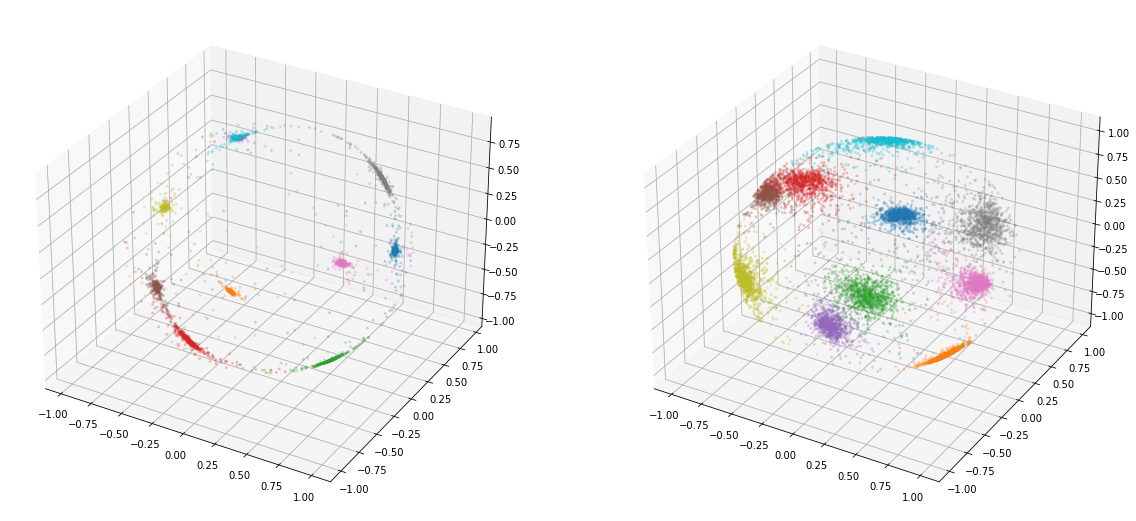

In [18]:
learn = Learner(dls, SimpleConv(nn.Linear(3,10)), metrics=accuracy)
learn.fit_one_cycle(5, 5e-3)
embs_softmax, ys_softmax  = get_embs(learn.model.eval(), dls.valid)
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()